# Gate based maxcut solver

The code below allows, given a graph, to obtain the maxcut of that graph.

The method consists of starting from a Hamiltonian that does not correspond to our graph but rather to a placement of the graph's points independently of each other; this is what we represent by the Hamiltonian $H_x$. Then, we construct an interaction Hamiltonian that maps the connections between the nodes of our graph, which we call the Hamiltonian $H_c$. The Hamiltonian $H_x$ has a well-known ground state. This method involves initializing the system in the ground state of the Hamiltonian $H_x$, then using the parameters $\eta$ to slowly evolve the Hamiltonian $H_{x}$ towards the Hamiltonian $H_c$. Since the evolution is slow, this ensures that the system remains in the ground state throughout the procedure, and thus, in the end, the system is in the ground state of the Hamiltonian associated with our graph $H_c$.

### The code

1. The first step is to implement the graph. We use the adjacency matrix of the graph. Since graphs are assumed to be undirected with a single weight, the adjacency matrix is symmetric and contains only 1s. This matrix is created using the randm_matrix function.

2. I create the function u_x which is the evolution operator of the Hamiltonian hx.

3. I create the function u_c which is the evolution operator of the Hamiltonian hc.

4. I create the function U_init() which creates a circuit that returns the ground state of hx.

5. I create the function u_n which applies the Suzuki-Trotter approximation of $U_{\eta}$. We notice that at each iteration, as $\frac{j - 1}{m(\eta -1}$ increases, $\frac{\eta - j}{m(\eta -1}$ decreases, which reflects the transition from the Hamiltonian hx to hc.

6. The function qaoa_circuit simply initializes the circuit in the ground state of $H_{x}$ before applying u_n.

7. The function ground_state_optimizer() in this function, I use the qaoa_circuit function with the evolve method to retrieve the state vector of our circuit after the evolution of our system: $$\ket{\Phi_{\eta,m}} = U_{\eta , m}U_{init}\ket{0}$$ Then I calculate c, which is the eigenvalue of this state vector: $$C = \bra{\Phi_{\eta,m}}H_{c}\ket{\Phi_{\eta,m}}$$ then we perform optimization on C to make it as small as possible and thus obtain a good approximation of the ground state $\ket{\Phi_{\eta,m}}$. The optimization doesn't seem to work very well, probably because the increments of $\eta$ and m are integers. I could solve this problem for m by changing the way I construct the u_n circuit. I could first obtain the matrix corresponding to $$ U_{c}(\frac{j - 1}{m(\eta - 1)})U_{x}(\frac{\eta - j}{m(\eta - 1)})$$ Then apply the power m and transform the resulting matrix into an observable, and finally add it to the u_c circuit.

8. Since the method outputs several basis vectors whose modulus is sufficiently large, I calculate the co je rechier les plus grand.
   
9. The function `calculate_maxcut_from_strings()` executes the final task. At this stage, I already have the bit string that corresponds to the partition of the maxcut. In fact, the "0" bits form one partition and the "1" bits form the other. For example, if I have "0101" with the order "0123", then the nodes from zero, namely {0, 2}, form one partition and {1, 3} form the other partition. It only remains to determine the number of edges that connect these partitions, which is the maxcut.

Unfortunately, I couldn't find a simple Python function to estimate the maxc for quick comparisonut.

Also, I notice a small bug at the end of execution. When I perform the following execution, I don't have any convergence. It's only after a third execution that I obtain results.keep the largest one.


In [1]:
from qiskit import QuantumCircuit , transpile , assemble 
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import UnitaryGate

from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_state_city


import numpy as np
from functools import reduce
from scipy.linalg import expm
import networkx as nx
from networkx.algorithms.approximation import maxcut
import matplotlib.pyplot as plt

from scipy.optimize import minimize

# Generation of the matrix J representing a graph with n nodes.

In [2]:
def randm_matrix(n):
    j = np.zeros((n,n), dtype=int)

    # Assign randomly two connections for each node
    for i in range(n):
        connections = np.random.choice(np.delete(np.arange(n), i), 2, replace=False)
        for conn in connections:
            j[i, conn] = 1
            j[conn, i] = 1
    
    return j


size_graphe = [3 , 4 , 5 , 6 , 7]

graph_list = []

for i in size_graphe:
    graph_list.append(randm_matrix(i))

# Evolution operator $U_{x}(dt)$

$H_{x} = \sum_{i}^{n}X_{i} = X_{1}\otimes I \otimes I \otimes .... \otimes I + I \otimes X_{2} \otimes I \otimes ... \otimes I + ... + I \otimes ... \otimes I \otimes X_{n}$


In [3]:
def u_x(time_evol , nb_nodes):
    """
        Implement the evolution operator for H_x.
        Returns a unitary operator.
    """
    x = np.array([[0, 1], [1, 0]], dtype=complex) 
    N = 2**(nb_nodes)
    hx = np.zeros((N, N)) # initialization of Hx hamiltonian with zero matrix
    
    #For each element i in the sum, we create a row matrix A that initially
    #contains only identity matrices. Then, I replace the positions i  
    #with X matrices. Afterward, I compute the tensor product 
    #in the order of the list, followed by the summation of the resulting matrices.
    for i in range(nb_nodes):
        A = [np.eye(2) for _ in range(nb_nodes)]  # Initialize A for each i, j
        A[i] = x
        tensor_product = reduce(np.kron, A)
        hx = hx + tensor_product
    
    ux = expm(-1j * time_evol* hx)
    unitary_gate_ux= UnitaryGate(ux , label= "Ux(dt = {})".format(time_evol))
    return unitary_gate_ux

# Evolution operator $U_{c}(dt)$

In [4]:
def u_c(J, time_evol, nb_nodes):
    """
    Implements the evolution operator of H_c.
    Returns a unitary operator.
    """
    # The number of nodes, nb_nodes, corresponds to the number of qubits,
    # and the size of the Ising Hamiltonian should be coherent.
    
    # J is the matrix corresponding to the graph; if there is a connection 
    # between nodes i and j, then J[i, j] = J[j, i] = 1, otherwise 0
    
    z = np.array([[1, 0], [0, -1]], dtype=complex) 
    N = 2**(nb_nodes)
    hc = np.zeros((N, N))  # Initialize the matrix with zeros
    
    # For each pair (i, j) in the sum, we create a row matrix A that initially
    # contains only identity matrices. Then, we replace the positions i and j 
    # with Z matrices. Afterward, we compute the tensor product 
    # in the order of the list, followed by the summation of the resulting matrices.
    for i in range(nb_nodes):
        for j in range(i + 1, nb_nodes):
            A = [np.eye(2) for _ in range(nb_nodes)]  # Initialize A for each i, j
            if J[i, j] != 0:
                A[i] = z
                A[j] = z
                tensor_product = reduce(np.kron, A)
                hc = hc + tensor_product

    uc = expm(-1j * time_evol * hc)
    unitary_gate = UnitaryGate(uc, label="Uc(dt = {})".format(time_evol))
    return unitary_gate

# Circuit to initialize the system to the ground state of the Hamiltonian $H_{x}$.

This choice is the most obvious general choice, as it assumes that initially the qubits are independent of each other, then they are allowed to evolve, interact with each other until they find the arrangement that minimizes their overall Hamiltonian.

Since the state $\ket{-}$ is the ground state of $X$, then $\ket{-} \otimes \ket{-} \otimes ... \otimes \ket{-}$ is the ground state of $H_{x}$.

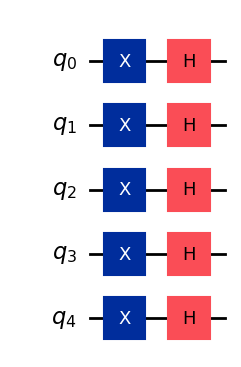

In [5]:
def U_init(nb_nodes):
    """
    Initilize the system

    return quantum cirucit
    """
    qc = QuantumCircuit(nb_nodes)
    qc.x(range(nb_nodes))
    qc.h(range(nb_nodes))
    
    return qc

U_init(5).draw('mpl')

# Global evolution operator $U_{\eta}$
By using the Suzuki-trotter approximation, we have
$$ U_{\eta} = \prod_{j = 1}^{\eta}\left[U_{c}(\frac{j - 1}{m(\eta - 1)})U_{x}(\frac{\eta - j}{m(\eta - 1)})\right]^{m}$$

In [6]:
def u_n(J , n , m ):
    #nb_nodes it the number of qubits
    nb_nodes = len(J)
    qc = QuantumCircuit(nb_nodes)
    for j in range(1 , n + 1):
        tc = (j - 1)/(m*(n - 1))
        tx = (n - j)/(m*(n - 1))
        for k in range(1, m + 1):
            qc.append(u_x(time_evol= tx , nb_nodes=nb_nodes) , [i for i in range(nb_nodes)])
            qc.append(u_c(J, tc, nb_nodes=nb_nodes) , [i for i in range(nb_nodes)])
        
    return qc

# This is the complete circuit from initialization to $U_{\eta}$

In [7]:
def qaoa_circuit(J , n , m):
    nb_nodes = len(J)
    qc = QuantumCircuit(nb_nodes)
    # initialization of the systeme at the ground state of H_x
    qc.append(U_init(nb_nodes=nb_nodes) , [i for i in range(nb_nodes)])
    qc.append(u_n(J, n = n , m = m ) , [i for i in range(nb_nodes)])
    #qc.measure_all()
    
    return qc

# Now i want to try to optimise a ground state firt i need $H_{c}$ 

In [8]:
def hc( J ):
    nb_nodes = len(J)
    #The number of node nb_nodes it is the number of number of qubit and ising_hamilt size should be coherent
    
    # J is the matrix corresponding to the graph; if there is a connection 
    # between nodes i and j, then J[i, j] = J[j, i] = 1, otherwise 0
    
    z = np.array([[1, 0], [0, -1]], dtype=complex) 
    N = 2**(nb_nodes)
    hc = np.zeros((N, N)) # Initialisation de la matrice apr la matrice nulle
    
    #For each pair (i, j) in the sum, we create a row matrix A that initially
    #contains only identity matrices. Then, I replace the positions i and j 
    #with Z matrices. Afterward, I compute the tensor product 
    #in the order of the list, followed by the summation of the resulting matrices.
    for i in range(nb_nodes):
        for j in range(i + 1, nb_nodes):
            A = [np.eye(2) for _ in range(nb_nodes)]  # Initialize A for each i, j
            if J[i, j] != 0:
                A[i] = z
                A[j] = z
                tensor_product = reduce(np.kron, A)
                hc = hc + tensor_product
    return hc

# Optimisation process

In [9]:
def ground_state_optimizer(J, init_m, init_n):
    def cost_function(x, J):
        m = int(x[0])  # Convert m integer
        n = int(x[1])  # Convert n integer
        qc = qaoa_circuit(J, n, m)
        num_qubits = qc.num_qubits
        zero_string = '0' * num_qubits
        sv = Statevector.from_label(zero_string)
        sv = sv.evolve(qc)
        C = np.dot(sv.data.conj().T, np.dot(hc(J), sv))
        return C.real

    bounds = [(0, None), (0, None)]  # for have n and m positives

    result = minimize(cost_function, [init_m, init_n], args=(J,), method='SLSQP', bounds=bounds)

    min_cost = result.fun
    optimal_m = int(result.x[0])
    optimal_n = int(result.x[1])

    qc = qaoa_circuit(J, optimal_n, optimal_m)
    num_qubits = qc.num_qubits
    zero_string = '0' * num_qubits
    optimal_sv = Statevector.from_label(zero_string).evolve(qc)

    return min_cost, optimal_sv, optimal_m, optimal_n



def dominant_basis_states(statevector, threshold=0.5):
    coeffs = statevector.data
    num_qubits = int(np.log2(len(coeffs)))  # get the number of qubits
    basis_states = [format(i, '0'+str(num_qubits)+'b') for i in range(2**num_qubits)]  # generate X-state basis 
    state_coeffs = dict(zip(basis_states, coeffs))  # Associate coefficients with base states
    dominant_states = [state for state, coeff in state_coeffs.items() if np.abs(coeff) > threshold]  #Filter states with a coefficient higher than the threshold."
    return dominant_states

In [10]:
def calculate_maxcut_from_strings(graph , strings):
    num_columns = len(strings)
    A = [[], []]
    # initailization of the two partitons
    partition_0 = []
    partition_1 = []

    A[0] = [i for i in range(num_columns)]
    A[1] = [char for char in strings]

    # Partition filling according to whether the nodes are associated with '1' or '0' bits    j = 0
    j = 0
    for i in A[1]:
        if i == '0':
            partition_0.append(A[0][j])
        else:
            partition_1.append(A[0][j])
        j = j + 1
        
    # Initialize a dictionary to store the connections for each node in the list.
    connexions = {node: 0 for node in partition_0}
    
    # Iterate over each node in the list
    for node in partition_0:
        # Iterate over the neighbors of the node
        for neighbor in graph.neighbors(node):
            # Check if the neighbor is not in the list of nodes
            if neighbor not in partition_0:
                # Increment the number of connections of the node
                connexions[node] += 1

    # Compute the sum of connections for all nodes in the list
    sum_connexions = sum(connexions.values())
    return sum_connexions

In [11]:
K = []
for i in [3 , 5 , 6 , 7]:
    K.append(randm_matrix(i))

In [12]:
matrix_3 , matrix_5 , matrix_6  , matrix_7 = K
J = [matrix_3 , matrix_5 , matrix_6  ,  matrix_7 ]

maxcut not found


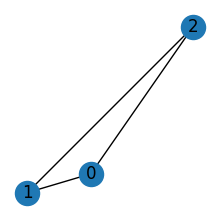

maxcut not found


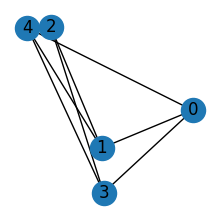

The maxcut by QAOA : 8


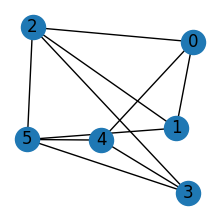

maxcut not found


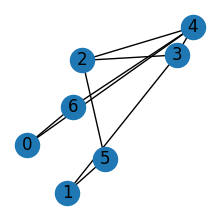

In [16]:
def graph_generator(matrix):
    graph = nx.from_numpy_array(matrix)
    return graph

for matrix in J:
    g = graph_generator(matrix)
    min_cost, optimal_sv, optimal_m, optimal_n = ground_state_optimizer(matrix , 10 , 10)
    dominant_states = dominant_basis_states(optimal_sv , threshold = 0.5)
    maxcut_list = []
    for state in dominant_states:
        maxcut_value = calculate_maxcut_from_strings(g , state)
        maxcut_list.append(maxcut_value)
    if maxcut_list == []:
        print('maxcut not found')
    else:
        print("The maxcut by QAOA :", max(maxcut_list)) 
        
    # nx.draw_random(g, with_labels= True)
    # plt.show()
    # Set the figure size
    plt.figure(figsize=(2, 2))
    nx.draw_random(g, with_labels=True)
    plt.show()